# Section 7

## Preliminaries

### Data Sources
This repository contains a file named `GC_NGC4365.fits`, which you will need for the excercises in this section. 

## Assignment

Complete the following problems. Use code cells to develop and run any Python code required and Markdown cells to respond to any auxilliary questions that ask you to interpret your results.

### Exercise 1 (AST4031 & AST5031):

In [Blom et al. (2012)](https://arxiv.org/abs/1207.6398) photometric data are presented to select globular cluster (GCs) candidates in the giant elliptical galaxy NGC4365.
The authors used the data to revisit the question of whether NGC4365 has a bimodal or trimodal GC color distribution and found support for three distinct GC color subpopulations.

In this practical section you will use new data from [Pota et al. (2013)](https://arxiv.org/abs/1304.6723) to re-explore the Blom et al. conclusion. The new data include photometry for a sample of spectroscopically confirmed (as opposed to photometric GC candidates) GCs in NGC4365. The data can be found in the `GC_NGC4365.fits` file that this repository includes. Use the **$g-i$** color to perform the analysis of the subpopulations.

1. Describe the GC distribution as a multigaussian model. Using [`scikit-learn` GaussianMixture](https://scikit-learn.org/stable/modules/mixture.html) and both the AIC and BIC criteria, decide whether three populations are really supported by the data. If not, report and discuss how many you do find.
2. Assign each GC to one of the components. Plot the probability as a function of GC color to show your results.  
3. Plot the RA and DEC of the GCs assigned to different populations. Are different populations spatially distributed in a different way within the galaxy?

## Solution

In [1]:
import numpy as np
import sklearn.mixture as skmix
import astropy as ap
import astropy.io.fits as apfits
import astropy.table as aptable

import scipy.stats as spstats
import scipy.stats.distributions as spdists

import matplotlib
import matplotlib.pyplot as mplplot

from IPython.core.display import display

%matplotlib inline

Begin by loading the data. As usual we'll make life easier by reading the data from the file into an `astropy.Table` data structure.
The `Table` contains several columns, that we'll need later in the assignment.

In [2]:
gcDataFilePath = "GC_NGC4365.fits"
gcDataFile = apfits.open(gcDataFilePath)
gcDataTable = aptable.Table(gcDataFile[1].data)
display(gcDataTable)

_RAJ2000,_DEJ2000,Type,Name,RAJ2000,DEJ2000,HV,e_HV,gmag,e_gmag,rmag,e_rmag,imag,e_imag
float64,float64,str3,str15,float64,float64,int16,int16,float32,float32,float32,float32,float32,float32
186.06139,7.301389999999998,CGC,NGC4365_GC1,186.06139,7.301389999999999,1634,7,21.913,0.018,21.293,0.014,21.065,0.014
186.07226999999997,7.2785400000000005,CGC,NGC4365_GC2,186.07226999999997,7.278539999999999,1390,13,23.882,0.031,23.073,0.023,22.751,0.023
186.07656999999995,7.2785400000000005,CGC,NGC4365_GC3,186.07656999999998,7.278539999999999,1232,5,21.147,0.017,20.448,0.013,20.158,0.012
186.07678999999996,7.268849999999997,CGC,NGC4365_GC4,186.07679,7.268849999999999,1379,8,22.73,0.021,22.194,0.018,21.984,0.017
186.08624999999995,7.327230000000002,CGC,NGC4365_GC5,186.08624999999998,7.327229999999999,1358,16,23.118,0.025,22.456,0.019,22.094,0.02
186.08633999999995,7.276190000000001,CGC,NGC4365_GC6,186.08633999999998,7.276189999999999,1300,37,23.664,0.029,23.031,0.023,22.808,0.024
186.08655,7.256420000000001,CGC,NGC4365_GC7,186.08655,7.256419999999999,1108,13,23.745,0.029,23.054,0.022,22.646,0.022
186.09019999999995,7.243449999999998,CGC,NGC4365_GC8,186.09019999999998,7.243449999999999,797,11,23.401,0.025,22.714,0.02,22.373,0.019
186.09171999999998,7.2481800000000005,CGC,NGC4365_GC9,186.09171999999998,7.248179999999999,1232,24,23.489,0.025,22.913,0.022,22.726,0.022


Next, we need to compute the $g-i$ colour for each of the globular clusters. Luckily, the columns of an `astropy.Table` behave very much like (augmented) `numpy.arrays` which means that we can simply subtract entire columsn from each other, **without any explicit loops**.

In [3]:
gcDataTable["gMinusIColour"] = gcDataTable["gmag"] - gcDataTable["imag"]

Now let's plot histograms of the colours we just computed and the magnitude values we subtracted.

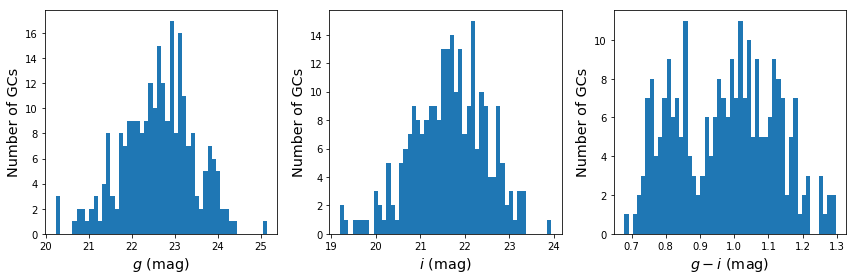

In [4]:
magFigure, magPanels = mplplot.subplots(figsize=(12, 4), ncols=3, nrows=1)

for columnLabel, panelLabel, panel in zip(
    ["gmag", "imag", "gMinusIColour"],
    ["$g$ (mag)", "$i$ (mag)", "$g-i$ (mag)"],
    magPanels.flatten(),
):
    panel.hist(
        gcDataTable[columnLabel], bins=len(gcDataTable[columnLabel]) // 5
    )
    panel.set_xlabel(panelLabel, fontsize="x-large")
    panel.set_ylabel("Number of GCs", fontsize="x-large")

mplplot.tight_layout()

Simply by inspecting the histogram of **$g-i$** colour, there is clear evidence for two populations. Evidence for a third population is difficult to discern by visual inspection.

To obtain more quantitative evidence for the presence (or otherwise) of a third population of globular clusters, we're going to use the `sklearn.mixture.GaussianMixture` class. This class computes a _Gaussian Mixture Model_ assuming an integer number of separate Gaussian components that we specify.

One downside of using a ready-made algorithm implementation is that we need to conform with its input requirements. Most relevantly in this case, `sklearn.mixture.GaussianMixture` expects two dimesional input data. 

_Aside:_ In fact, this requirement stems from the fact that the Gaussian components that the class considers can be multi-dimensional. In that case we would need to supply an array of vectors with the separate elements of each vector corresponding to dimension of the data. In this case, we only have one data dimension - $g-i$, so we'll just supply an array of single element vectors!

We can expand the number of dimensions straightforwardly using the `numpy.atleast_2d` function.

In [5]:
mag2dData = np.atleast_2d(np.array(gcDataTable["gMinusIColour"])).T
print(
    "Shape before atleast_2d:",
    gcDataTable["gMinusIColour"].shape,
    "\nShape after atleast_2d:",
    mag2dData.shape,
)

Shape before atleast_2d: (251,) 
Shape after atleast_2d: (251, 1)


The `sklearn.mixture.GaussianMixture` class derives the best fitting component parameters for its model using the _Expectation Maximization_ algorithm. To run the algorithm we need to invoke the `fit_predict` methoud of the class. This method also returns a list of labels, corresponding uniquely to each of the input data, which indicate which of the model components is most likely to have generated that datum.

We'll compute mixture models for model component multiplicities in the range $[1,9]$.  

In [6]:
## Toggle verbose text output
verbose = False
## Consider mixture models with 1-9 components
numComponentOptions = range(1, 10)

## A container to store the data-component assignment labels for each model.
componentLabels = {}
## A container to store the mixture models themselves.
gaussianMixtureModels = {}

## Loop over component multiplicities
for numComponents in numComponentOptions:
    ## Instantiate a mixture model and store it in the
    gaussianMixtureModels[numComponents] = skmix.GaussianMixture(
        n_components=numComponents, n_init=1000, covariance_type="spherical"
    )

    ## Compute the best fitting model component parameters and store the
    ## data-component assignment labels
    componentLabels[numComponents] = gaussianMixtureModels[
        numComponents
    ].fit_predict(mag2dData)

    if verbose:
        print(
            "{} components:".format(numComponents),
            "AIC:",
            gaussianMixtureModels[numComponents].aic(mag2dData),
            "BIC:",
            gaussianMixtureModels[numComponents].bic(mag2dData),
            "Means:",
            gaussianMixtureModels[numComponents].means_.flatten(),
            "Covariances:",
            gaussianMixtureModels[numComponents].covariances_.flatten(),
            sep="\n",
        )

To determine the number of model components that is best supported by the data, we'll use the _Akaike Information Criterion_ (AIC) and the _Bayesian Information Criterion_ (BIC). Recall from the leactures that models that minimize the values of BIC and/or AIC have the most likely number of components.

We'll plot the two information criteria verus model component multiplicity and visually search for a minimum.

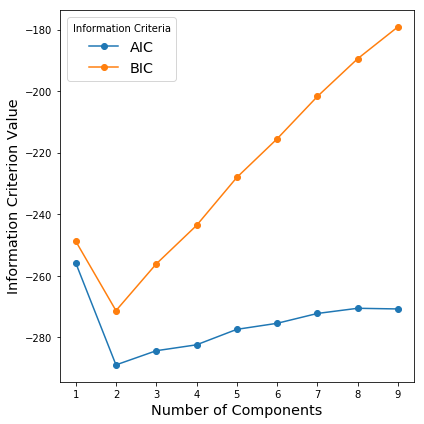

In [7]:
aicValues = [
    gaussianMixtureModels[numComponents].aic(mag2dData)
    for numComponents in numComponentOptions
]
bicValues = [
    gaussianMixtureModels[numComponents].bic(mag2dData)
    for numComponents in numComponentOptions
]

metricAxes = mplplot.figure(figsize=(6, 6)).add_subplot(1, 1, 1)

metricAxes.plot(numComponentOptions, aicValues, label="AIC", marker="o")
metricAxes.plot(numComponentOptions, bicValues, label="BIC", marker="o")

metricAxes.set_ylabel("Information Criterion Value", fontsize="x-large")
metricAxes.set_xlabel("Number of Components", fontsize="x-large")
metricAxes.legend(title="Information Criteria", fontsize="x-large")

mplplot.tight_layout()

Both the BIC and AIC metrics have a clear minimum favouring the 2-component model. This does **not** provide compelling evidence for three globular cluster populations.  

Now let's focus more closely on the models with two and three components. First, we can use the `predict_proba` method defined by the `sklearn.mixture.GaussianMixture` class to compute the probability that each datum corresponds with a particular model component. We'll plot these values directly and also using the "probability band" representation shown in the lectures. In this representation the vertical extent of the coloured bands at each value of $g-i$ indicates the probability that the component represented by the band would generate a globular cluster having that $g-i$ colour. The code to generate that plot is a little involved, but commented heavily in case you're interested.

Note that the plotting code frequently uses the transpose (`T`) operator to convert `M`x`N` arrays into `N`x`M`. This is often useful in combination with the `*` operator. When used as a prefix for arrays, the `*` operator "unpacks" the outermost dimension e.g. it converts an `M`x`N` array into `M` arrays of length `N`.

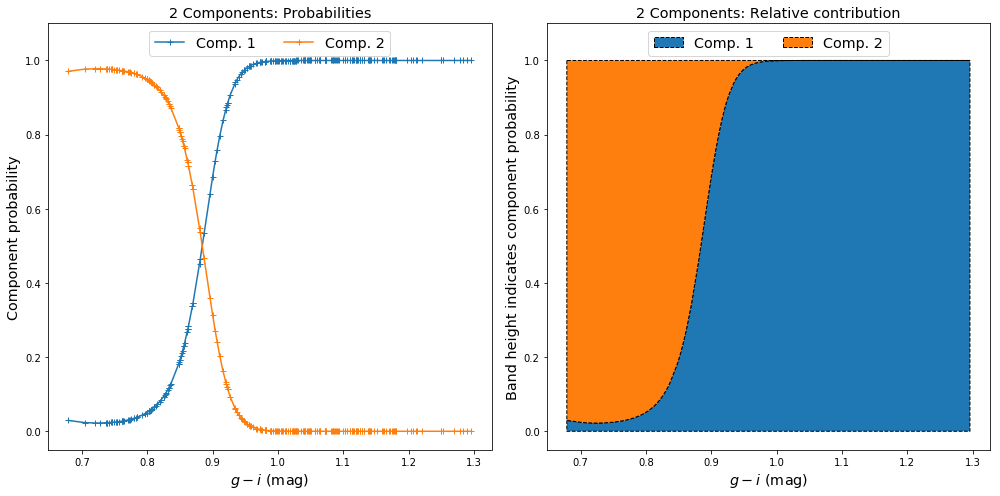

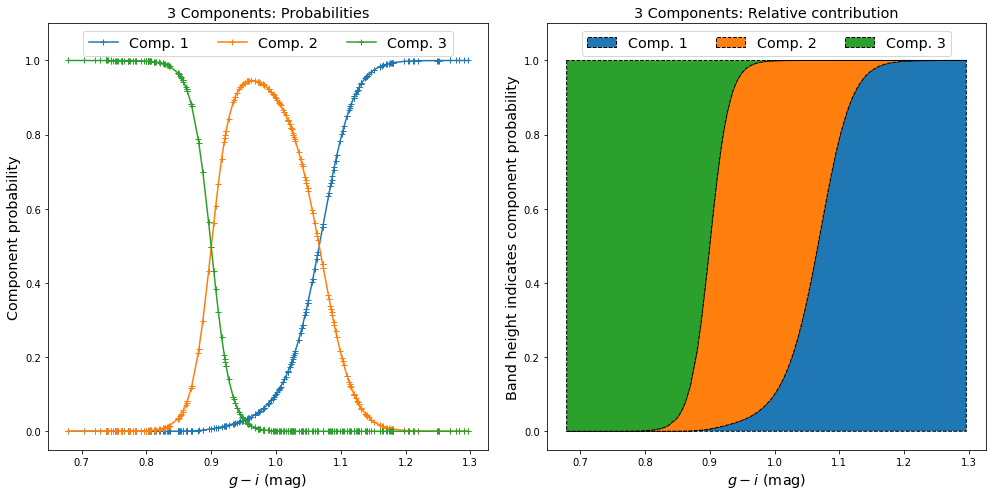

In [8]:
## Consider mixture models with 2 and 3 components
restrictedNumCompOpts = range(2, 4)

## A container to store the probabilities that each component
## generated a particular datum.
componentProbabilities = {}

## Loop over mixture models with 2 and 3 components
for numComponents in restrictedNumCompOpts:
    ## Compute the probability that each datum corresponds with
    ## a particular model component.
    componentProbabilities[numComponents] = gaussianMixtureModels[
        numComponents
    ].predict_proba(mag2dData)

    componentProbsFigure, componentProbsPanels = mplplot.subplots(
        figsize=(14, 7), ncols=2, nrows=1
    )

    ## Loop over individual model components
    for componentCounter, componentProb in enumerate(
        componentProbabilities[numComponents].T
    ):
        ## Simple plot of the component probabilities at each data
        ## abscissa. Note that the data must be coherently sorted
        ## in ascending order of g-i colour for plotting
        componentProbsPanels[0].plot(
            *np.array(
                sorted(
                    zip(mag2dData.T[0], componentProb),
                    key=lambda coords: coords[0],
                )
            ).T,
            label="Comp. {}".format(componentCounter + 1),
            marker="+",
        )

        ## Plot using the "probability band" representation shown in the lectures.
        ## This expression is a little involved...
        componentProbsPanels[1].fill_between(
            ## Use the "*" operator to unpack a 2D array into three 1D arrays for plotting
            *np.array(
                ## Need to coherently sort the data into ascending order of (g-i) magnitude.
                sorted(
                    zip(
                        mag2dData.T[0],
                        ## The sum of the probabilities of all components with IDs less than
                        ## this component.
                        np.sum(
                            componentProbabilities[numComponents][
                                :,
                                list(
                                    filter(
                                        lambda x: x < componentCounter,
                                        range(numComponents),
                                    )
                                ),
                            ],
                            axis=1,
                        ),
                        ## The sum of the probabilities of all components with IDs less than
                        ## or equal to this component.
                        np.sum(
                            componentProbabilities[numComponents][
                                :,
                                list(
                                    filter(
                                        lambda x: x <= componentCounter,
                                        range(numComponents),
                                    )
                                ),
                            ],
                            axis=1,
                        ),
                    ),
                    ## Sorting key
                    key=lambda coords: coords[0],
                )
                ## Note that the transpose allows the result to be unpacked into two
                ## arrays with the same length as the data using the "*" operator.
            ).T,
            label="Comp. {}".format(componentCounter + 1),
            linestyle="--",
            edgecolor="k",
        )

    componentProbsPanels[0].set_title(
        "{} Components: Probabilities".format(numComponents), fontsize="x-large"
    )
    componentProbsPanels[0].legend(
        fontsize="x-large", loc="upper center", ncol=numComponents
    )
    componentProbsPanels[0].set_xlabel("$g-i$ (mag)", fontsize="x-large")
    componentProbsPanels[0].set_ylabel(
        "Component probability", fontsize="x-large"
    )

    componentProbsPanels[0].set_ylim(componentProbsPanels[0].get_ylim()[0], 1.1)

    componentProbsPanels[1].set_title(
        "{} Components: Relative contribution".format(numComponents),
        fontsize="x-large",
    )
    componentProbsPanels[1].legend(
        fontsize="x-large", loc="upper center", ncol=numComponents
    )
    componentProbsPanels[1].set_xlabel("$g-i$ (mag)", fontsize="x-large")
    componentProbsPanels[1].set_ylabel(
        "Band height indicates component probability", fontsize="x-large"
    )

    componentProbsPanels[1].set_ylim(componentProbsPanels[1].get_ylim()[0], 1.1)

    mplplot.tight_layout()

Let's also plot the $g-i$ colour data that were assigned to each component.

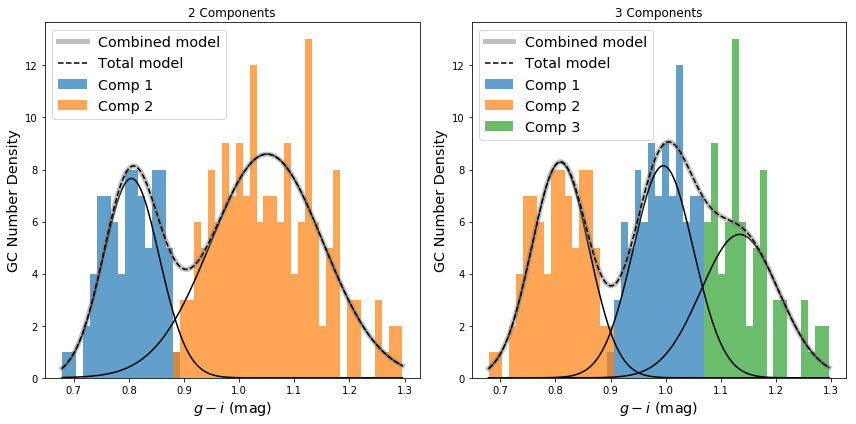

In [9]:
magFigure, magPanels = mplplot.subplots(figsize=(12, 6), ncols=2, nrows=1)

## Loop over mixture models...
for numComponents, panel in zip(restrictedNumCompOpts, magPanels.flatten()):
    mixtureModel = gaussianMixtureModels[numComponents]
    pointComponentLabels = componentLabels[numComponents]

    ## Binning definition for histogram
    binBounds = np.linspace(
        mag2dData.flatten().min(), mag2dData.flatten().max(), 50
    )

    ## Abscissae definition for models
    abscissae = np.linspace(
        mag2dData.flatten().min(), mag2dData.flatten().max(), 200
    )

    ## Scaling factor for PDF models to match histogram scaling (sample size / bin width)
    modelScaleFactor = mag2dData.flatten().size * (binBounds[1] - binBounds[0])

    componentModels = []
    ## Loop over components of this mixture model...
    for (componentCounter, pointComponentLabel) in enumerate(
        np.unique(pointComponentLabels)
    ):
        ## Generate a colour specification string.
        colourString = "C{}".format(pointComponentLabel)

        ## Plot a histogram of the data that were assigned to this component
        panel.hist(
            mag2dData.flatten()[pointComponentLabels == pointComponentLabel],
            bins=binBounds,
            alpha=0.7,
            facecolor=colourString,
            label="Comp {}".format(componentCounter + 1),
        )

        ## Plot best fitting Gaussian component model.
        ## Note that we normalize using the `weights_` attribute
        ## of `sklearn.mixture.GaussianMixture`

        componentModels.append(
            mixtureModel.weights_.flatten()[componentCounter]
            * spdists.norm(
                loc=mixtureModel.means_.flatten()[componentCounter],
                scale=np.sqrt(
                    mixtureModel.covariances_.flatten()[componentCounter]
                ),
            ).pdf(abscissae)
        )
        panel.plot(abscissae, modelScaleFactor * componentModels[-1], c="k")

    ## Plot the total model. There are two ways to do this. We can sum the
    ## individual component models or use the `score_samples` method defined
    ## by `sklearn.mixture.GaussianMixture`.

    ## Summing the individual components
    panel.plot(
        abscissae,
        modelScaleFactor * np.sum(np.array(componentModels), axis=0),
        c="grey",
        lw=5,
        alpha=0.5,
        label="Combined model",
    )

    ## Using `score_samples`
    panel.plot(
        abscissae,
        modelScaleFactor
        * np.exp(mixtureModel.score_samples(np.atleast_2d(abscissae).T)),
        c="k",
        ls="--",
        label="Total model",
    )

    panel.set_xlabel("$g-i$ (mag)", fontsize="x-large")
    panel.set_ylabel("GC Number Density", fontsize="x-large")
    panel.legend(fontsize="x-large")
    panel.set_title("{} Components".format(numComponents))

mplplot.tight_layout()

Now we can use the data labels for the 2 and 3 component models to highlight globular clusters assigned to each component class in celestial coordinates. The original data table includes two columns listing the _Right Ascension_ (RA, `_RAJ2000`) and _Declination_ (DEC, `_DEJ2000`). We can make a simple scatter plot for data in each class and `matplotlib` will hepfully handle the colourisation for us!

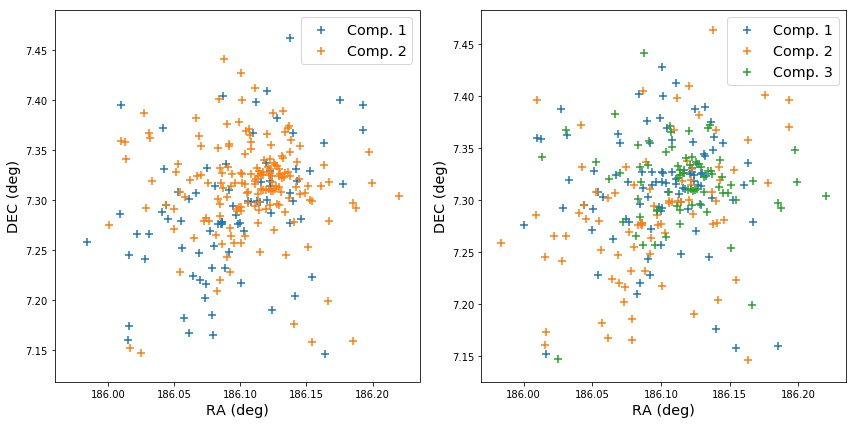

In [10]:
raDecFigure, raDecPanels = mplplot.subplots(figsize=(12, 6), ncols=2, nrows=1)

## Loop over mixture models...
for numComponents, panel in zip(restrictedNumCompOpts, raDecPanels.flatten()):
    mixtureModel = gaussianMixtureModels[numComponents]
    pointComponentLabels = componentLabels[numComponents]

    for componentCounter, pointComponentLabel in enumerate(
        np.unique(pointComponentLabels)
    ):
        panel.scatter(
            gcDataTable["_RAJ2000"][
                pointComponentLabels == pointComponentLabel
            ],
            gcDataTable["_DEJ2000"][
                pointComponentLabels == pointComponentLabel
            ],
            label="Comp. {}".format(componentCounter + 1),
            s=50,
            marker="+",
        )

    panel.set_xlabel("RA (deg)", fontsize="x-large")
    panel.set_ylabel("DEC (deg)", fontsize="x-large")
    panel.legend(fontsize="x-large")

mplplot.tight_layout()

There is very little evidence that the different populations are spatially distinct for either the 2 or 3 component model.

### Exercise 2 (AST5031 Only):

1. Write your own **Expectation Maximization** algorithm to compute the best fit parameters of the $M$ gaussian components you found with sklearn.
2. Compare your results with those derived with `scikit-learn` and comment on your observations.

The *expectation maximization* algorithm is an iterative procedure. For a *Gaussian Mixture Model*, each iteration entails computation of four quantities in two semantically distinct _steps_:

1. The E-Step computes or updates an estimate of the responsibility of each model component $j$ for generating each datum $i$.
    * $w_{ij}$ is a _responsibilities_ matrix that quantifies the probability $p(j|x_{i})$ of observing datum $i$ given the presence of component $j$.
    \begin{equation}
    w_{ij}=\frac{\alpha_{j}~N(\mu_{j}, \sigma_{j})}{\sum\limits_{j=1}^{M}\alpha_{j}~N(\mu_{j}, \sigma_{j})}
    \end{equation}
2. The M-Step computes the best estimates of the model component means $\mu_{j}$, variances $\sigma_{j}^{2}$ and coefficients $\alpha_{j}$ 
    * $\mu_{j}$ is a vector encapsulating the best estimates of the mean value for each of the Gaussian functions comprising the mixture model.
    \begin{equation}
    \mu_{j} = \frac{\sum\limits_{i=1}^{N}w_{ij}x_{i}}{\sum\limits_{i=1}^{N}w_{ij}}
    \end{equation}
    * $\sigma_{j}^{2}$ is a vector encapsulating the best estimates of the variance for each of the Gaussian functions comprising the mixture model. 
    \begin{equation}
    \sigma_{j}^{2} = \frac{\sum\limits_{i=1}^{N}w_{ij}(x_{i}-\mu_{j})^{2}}{\sum\limits_{i=1}^{N}w_{ij}}
    \end{equation}
    * $\alpha_{j}$ is a vector of weights parameterizing the best estimates for the relative contribution of each Gaussian component to the mixture model.
    \begin{equation}
    \alpha_{j} = \frac{1}{N}\sum\limits_{i=1}^{N}w_{ij}
    \end{equation}

Before initiating the algorithm, the $\mu_{j}$, $\sigma_{j}^{2}$ and $\alpha_{j}$ must be initialized. The success of the algorithm does not depend critically on these initial values. We'll assign mean values that are evenly distributed within the range of $g-i$ encompassed by the data. We'll initialize all component variances to be equal to the *standard deviation* ($\sigma\neq\sigma^{2}$ of the $g-i$ distribution. Finally we'll initialize all model components with equal coefficients $\alpha_{j} = 1/M$. Note that this fulfills the requirement that the sum of all coefficents equal unity.

The initial $w_{ij}$ are computed during the _E-step_ at the beginning of the first iteration. Note that during the _M-Step_, the variances for each iteration must be computed _after_ the means upon which their computation depends. 

We'll define functions that compute the various quantities that the algorithm entails, and a control function that invokes them all in the appropriate sequence.

In [11]:
def bestMeans(responsibilities, data):
    """Compute the ML estimates for the Gaussian component means.
    
    Args:
    responsibilities - a MxN responsibilities matrix. 
    data - an N-element data vector
    
    Returns:
    M-element vector. 1 element per model component.
    """
    return np.sum(responsibilities * data, axis=1) / np.sum(
        responsibilities, axis=1
    )


def bestVariances(responsibilities, means, data):
    """Compute the ML estimates for the Gaussian component variances.
    
    Args:
    responsibilities - a MxN responsibilities matrix. 
    means - an M-element vector of ML estimates for the gaussian component means.
    data - an N-element data vector
    
    Returns:
    M-element vector. 1 element per model component.
    """
    summand = responsibilities * (gMinusIColour - means[:, np.newaxis]) ** 2.0
    return np.sum(summand, axis=1) / np.sum(responsibilities, axis=1)


def bestAlphas(responsibilities):
    """Compute the sum of all responsibilities for each component
    
    Args:
    responsibilities - a MxN responsibilities matrix. 
    
    Returns:
    M-element vector. 1 element per model component.
    """
    alphas = np.sum(responsibilities, axis=1) / responsibilities.shape[1]

    assert np.abs(np.sum(alphas - 1.0) < 1e-5)
    return alphas


def bestResponsibilities(alphas, means, variances, data):
    """Compute the responsibility of each model component for each 
    datum, given the most likely component means and variances.
    
    Args:
    alphas - an M-component vector containing the sums of all responsibilities for each component.
    means - an M-component vector of ML estimates for the gaussian component means.
    variances - an M-component vector of ML estimates for the gaussian component variances.
    data - an N-component data vector    
    
    Returns:
    MxN matrix. 
    """
    summand = alphas * spdists.norm(loc=means, scale=np.sqrt(variances)).pdf(
        data[:, np.newaxis]
    )
    return summand.T / np.sum(summand, axis=1)


def expectationMaximization(means, variances, alphas, data, tolerance=1e-8):
    """
    Execute the expectation maximization algorithm to determine the best parameters
    for a Gaussian mixture model.
    
    Args:
    means - an M-component vector of initial values for the gaussian component means.
    variances - an M-component vector of initial values for the gaussian component variances.
    alphas - an M-component vector of initial values for the coefficients each component. 
    data - an N-element data vector.
    tolerance - used to determine algorithm convergence. No quantity may change by more than
        this value between successive iterations.
        
    Returns:
    Three arrays containing the component means, variances and coefficients for all iterations.
    """

    allMeans = [means.copy()]
    allVariances = [variances.copy()]
    allAlphas = [alphas.copy()]

    maxDelta = np.inf

    while maxDelta > tolerance:
        ## E-Step: Update responsibilities
        responsibilities = bestResponsibilities(alphas, means, variances, data)

        ## M-step: Compute best estimates for mean, sigma and alpha
        deltaMeans = means - bestMeans(responsibilities, data)
        means -= deltaMeans
        deltaVariances = variances - bestVariances(
            responsibilities, means, data
        )
        variances -= deltaVariances
        deltaAlphas = alphas - bestAlphas(responsibilities)
        alphas -= deltaAlphas

        maxDelta = np.concatenate(
            [deltaMeans, deltaVariances, deltaAlphas]
        ).max()

        allMeans.append(means.copy())
        allVariances.append(variances.copy())
        allAlphas.append(alphas.copy())

    return np.array(allMeans), np.array(allVariances), np.array(allAlphas)

Now we'll invoke our algorithm for several component multiplicities. The function we wrote returns data that let us reconstruct the algorithm's progress towards its solution.

In [12]:
allMeans = {}
allVariances = {}
allAlphas = {}

gMinusIColour = np.array(gcDataTable["gMinusIColour"])

for numComponents in numComponentOptions:
    ## Initial guess for mean values. Evenly distributed in the data range
    means = np.linspace(
        gMinusIColour.min(), gMinusIColour.max(), numComponents + 2
    )[1:-1]
    ## Initial guess for variances. All equal to the data standard deviation.
    variances = np.ones(shape=numComponents) * gMinusIColour.std()
    ## Initial guess for model component weights, normalized vector of evenly spaced
    ## values on the interval (0,1).
    alphas = np.linspace(0, 1, numComponents + 2)[1:-1]
    alphas /= np.linalg.norm(alphas)

    ## Execute the expectation maximization algorithm
    allMeans[numComponents], allVariances[numComponents], allAlphas[
        numComponents
    ] = expectationMaximization(means, variances, alphas, gMinusIColour)

Now we'll define a function to plot the algorithm progress and the best fitting solution.

In [13]:
def plotExpectMax(
    numComponents,
    allMeans,
    allVariances,
    allAlphas,
    data,
    dataLabel="g-i (mag)",
):
    expectMaxFigure, expectMaxPanels = mplplot.subplots(
        figsize=(8, 12), ncols=1, nrows=2, gridspec_kw=dict(hspace=0)
    )

    expectMaxPanels[0].xaxis.set_visible(False)
    _, binBounds, _ = expectMaxPanels[0].hist(
        data, bins=30, density=True, fc="grey", alpha=0.3
    )

    componentModels = []
    for componentCounter in range(numComponents):
        sigma = np.sqrt(allVariances[numComponents])
        colourString = "C{}".format(componentCounter)

        abscissae = np.linspace(binBounds.min(), binBounds.max(), 100)
        componentModels.append(
            allAlphas[numComponents][-1, componentCounter]
            * spdists.norm(
                loc=allMeans[numComponents][-1, componentCounter],
                scale=sigma[-1, componentCounter],
            ).pdf(abscissae)
        )

        expectMaxPanels[0].plot(abscissae, componentModels[-1], c=colourString)

        expectMaxPanels[0].axvline(
            x=allMeans[numComponents][-1, componentCounter],
            c=colourString,
            ls="--",
        )
        expectMaxPanels[0].axvline(
            x=allMeans[numComponents][-1, componentCounter]
            - sigma[-1, componentCounter],
            c=colourString,
            ls="dotted",
        )
        expectMaxPanels[0].axvline(
            x=allMeans[numComponents][-1, componentCounter]
            + sigma[-1, componentCounter],
            c=colourString,
            ls="dotted",
        )

        expectMaxPanels[1].plot(
            allMeans[numComponents][:, componentCounter],
            np.arange(allMeans[numComponents].shape[0]),
            ls="solid",
            c=colourString,
        )
        expectMaxPanels[1].fill_betweenx(
            y=np.arange(allMeans[numComponents].shape[0]),
            x1=allMeans[numComponents][:, componentCounter]
            - sigma[:, componentCounter],
            x2=allMeans[numComponents][:, componentCounter]
            + sigma[:, componentCounter],
            alpha=0.3,
            linestyle="--",
            facecolor=colourString,
            edgecolor=colourString,
        )

    expectMaxPanels[0].plot(
        abscissae, np.sum(np.array(componentModels), axis=0), c="k", ls="--"
    )

    expectMaxPanels[0].set_title("{} Components".format(numComponents))
    expectMaxPanels[0].set_ylabel("Number density", fontsize="x-large")

    expectMaxPanels[1].set_yscale("log")
    expectMaxPanels[1].set_ylim(1, allMeans[numComponents].shape[0])
    expectMaxPanels[1].set_xlim(*expectMaxPanels[0].get_xlim())
    expectMaxPanels[1].set_ylabel("Number of iterations", fontsize="x-large")
    expectMaxPanels[1].set_xlabel(dataLabel, fontsize="x-large")

    mplplot.tight_layout()

Finally, we can plot the results of our algorithm for different component multiplicities.

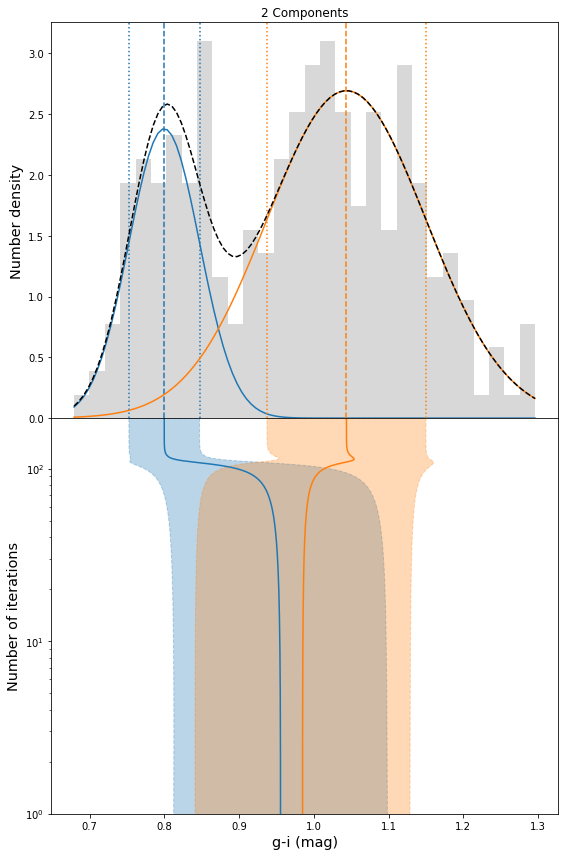

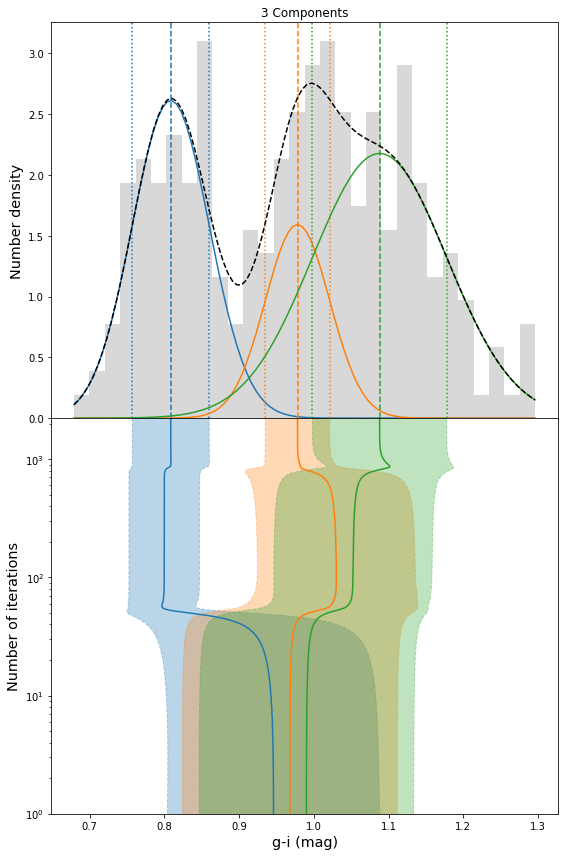

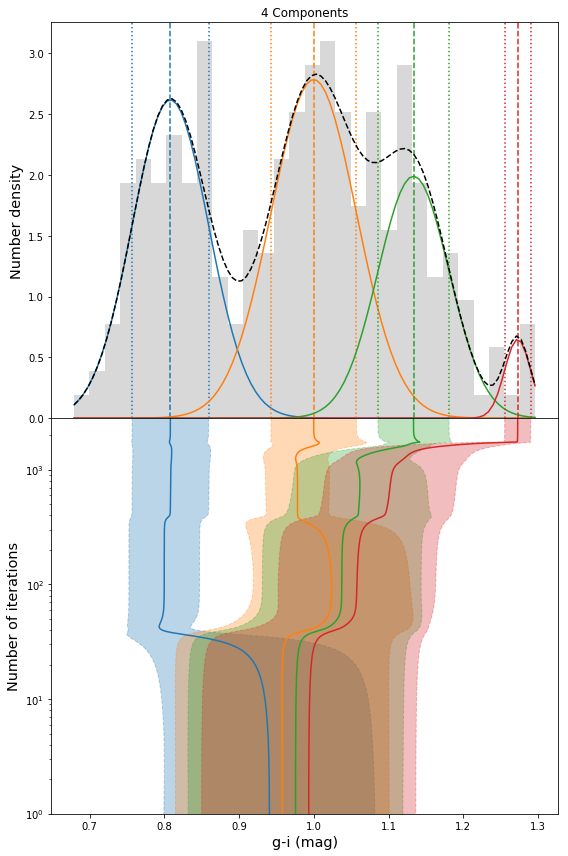

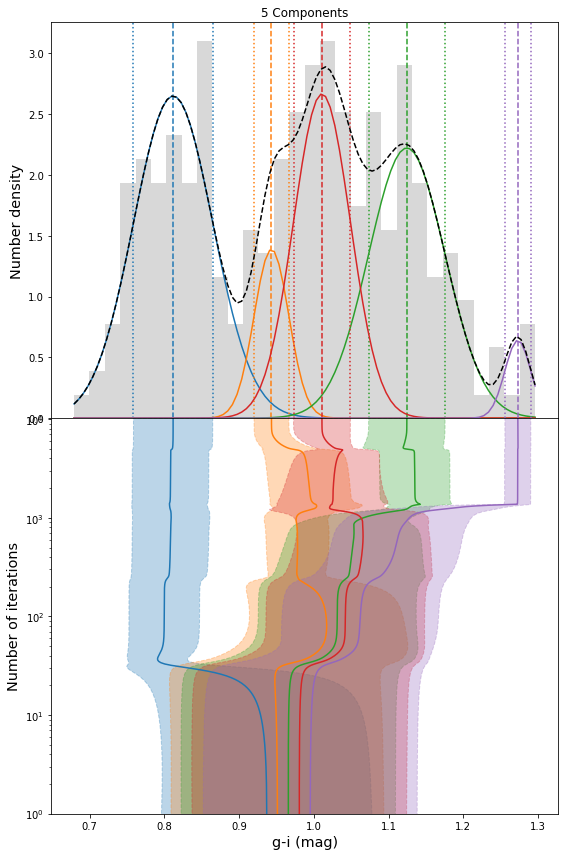

In [14]:
for numComponents in range(2, 6):
    plotExpectMax(
        numComponents, allMeans, allVariances, allAlphas, gMinusIColour
    )

Now we can print the best fitting model component parameters and compare them with the `sklearn.mixture.GaussianMixture` results.

In [15]:
for numComponents in restrictedNumCompOpts:
    print("{} Components:".format(numComponents))

    mixtureModelResults = np.array(
        sorted(
            zip(
                gaussianMixtureModels[numComponents].means_.flatten(),
                gaussianMixtureModels[numComponents].covariances_.flatten(),
            )
        )
    )
    customModelResults = np.array(
        sorted(
            zip(
                allMeans[numComponents][-1].flatten(),
                allVariances[numComponents][-1].flatten(),
            )
        )
    )

    print("GaussianMixture Means: {}".format(mixtureModelResults[:, 0]))
    print("Custom Algorithm Means: {}".format(customModelResults[:, 0]))

    print("GaussianMixture Variances: {}".format(mixtureModelResults[:, 1]))
    print("Custom Algorithm Variances: {}".format(customModelResults[:, 1]))

2 Components:
GaussianMixture Means: [0.80472679 1.05047221]
Custom Algorithm Means: [0.79967495 1.04357037]
GaussianMixture Variances: [0.00257138 0.01031438]
Custom Algorithm Variances: [0.00223457 0.01131614]
3 Components:
GaussianMixture Means: [0.80886848 0.99566034 1.13404997]
Custom Algorithm Means: [0.80842627 0.97806533 1.08795291]
GaussianMixture Variances: [0.00267912 0.00297726 0.00496383]
Custom Algorithm Variances: [0.00265098 0.00185988 0.00808701]


For the two component model, out algorithm produces a very similar result to the `sklearn.mixture.GaussianMixture` version of the algorithm. The final result in the three component case differs to a greater extent. In particular the final variances differ by factors $\sim 2$.